# Importar librerías (funciones) a usar

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (f1_score, recall_score, precision_score, roc_auc_score, accuracy_score,
                            r2_score, mean_absolute_percentage_error, mean_squared_error)
from sklearn.model_selection import KFold, train_test_split

# Importar dataset de la prueba

In [2]:
fraud_df = pd.read_csv('Descargas/MercadoLibre Inc. Data Scientist Hiring Test - Fraud Dataset - Data (2) (2).csv', 
                       thousands = ',', decimal = '.')

# Exploración inicial

### Nombres de columnas

In [3]:
fraud_df.columns

Index(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
       'O', 'P', 'Q', 'R', 'S', 'Monto', 'Fraude'],
      dtype='object')

### Estructura básica (preview) del DataFrame

In [4]:
fraud_df.head()

,A,B,C,D,E,F,G,H,I,J,...,L,M,N,O,P,Q,R,S,Monto,Fraude
0,0,10,50257.0,0,0,0.0,0.0,0,0,UY,...,0,3,1,0,5,0.0,0.0,7.25,37.51,1
1,0,10,29014.0,0,0,0.0,0.0,0,0,UY,...,0,1,1,0,3,0.0,0.0,11.66,8.18,1
2,0,7,92.0,0,1,0.0,0.0,0,1,UY,...,0,3,1,0,2,0.0,0.0,86.97,13.96,1
3,9,16,50269.0,0,0,0.0,0.0,0,0,UY,...,0,3,1,0,5,0.0,0.0,2.51,93.67,1
4,0,8,8180.0,0,0,0.0,0.0,0,0,UY,...,0,1,1,0,1,0.0,0.0,25.96,135.40,1


In [5]:
fraud_df.shape

(16880, 21)

### Descripción de cada columna junto con tipo de dato

In [6]:
fraud_df.dtypes

A           int64
B           int64
C         float64
D           int64
E           int64
F         float64
G         float64
H           int64
I           int64
J          object
K         float64
L           int64
M           int64
N           int64
O           int64
P           int64
Q         float64
R         float64
S         float64
Monto     float64
Fraude      int64
dtype: object

In [7]:
for i in fraud_df.columns:
    print(i, ' : ', fraud_df[i].dtype)
    print(fraud_df[i].describe())

A  :  int64
count    16880.000000
mean         0.309242
std          1.094064
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         30.000000
Name: A, dtype: float64
B  :  int64
count    16880.000000
mean         7.645379
std          4.686494
min         -1.000000
25%          4.000000
50%          7.000000
75%         11.000000
max         20.000000
Name: B, dtype: float64
C  :  float64
count     13683.000000
mean      39235.339984
std       91045.252879
min           0.000000
25%        1172.000000
50%        6173.000000
75%       26888.500000
max      617324.000000
Name: C, dtype: float64
D  :  int64
count    16880.000000
mean         0.198697
std          2.042959
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        180.000000
Name: D, dtype: float64
E  :  int64
count    16880.000000
mean         0.433709
std          1.537297
min          0.000000
25%          0.000000
50%          0.00000

### Tipo de dato y porcentaje de entradas nulas por columna

In [8]:
rows = len(fraud_df)
for i in fraud_df.columns:
    print(i, ' : ', fraud_df[i].dtype)
    print(fraud_df[i].isna().sum() / rows )

A  :  int64
0.0
B  :  int64
0.0
C  :  float64
0.1893957345971564
D  :  int64
0.0
E  :  int64
0.0
F  :  float64
0.0
G  :  float64
0.0
H  :  int64
0.0
I  :  int64
0.0
J  :  object
0.0
K  :  float64
0.762085308056872
L  :  int64
0.0
M  :  int64
0.0
N  :  int64
0.0
O  :  int64
0.0
P  :  int64
0.0
Q  :  float64
0.0
R  :  float64
0.0
S  :  float64
0.0
Monto  :  float64
0.0
Fraude  :  int64
0.0


### Desbalance de clase a predecir

In [9]:
fraud_df['Fraude'].value_counts(normalize=True)

0    0.726836
1    0.273164
Name: Fraude, dtype: float64

### Desbalance de clase a predecir dónde la columna C es nula

No reviso la columna K porque dado que más del 75% de sus valores son nulos y por simplicidad, no la tendré en cuenta

In [10]:
fraud_df.loc[fraud_df['C'].isna(),'Fraude'].value_counts(normalize=True)

0    0.827025
1    0.172975
Name: Fraude, dtype: float64

Dado que el desbalance cambia significativamente entre las transacciones con presencia de la variable C y los que no la tienen, se puede intuir que la variable, en sí misma, puede tener información relevante sobre la transacción (orientado a temas de fraude)

In [11]:
fraud_df.loc[fraud_df['K'].isna(),'Fraude'].value_counts(normalize=True)

0    0.754509
1    0.245491
Name: Fraude, dtype: float64

### Comparacíón sencilla de la distribución de la columna C dado fraude y dado no fraude

Con el fin de verificar qué tan predictiva puede ser dicha variable en un potencial modelo y si vale la pena dejarla o no en el mismo. De haber diferencias sustanciales en distribución, se puede considerar mantener como columna y buscar estrategias de imputación

In [12]:
print(fraud_df.loc[fraud_df['Fraude'] == 1,'C'].describe())
print(fraud_df.loc[fraud_df['Fraude'] == 0,'C'].describe())

count      4058.000000
mean      44741.403154
std       97568.417546
min           0.000000
25%        1406.250000
50%        7772.000000
75%       30053.250000
max      617324.000000
Name: C, dtype: float64
count      9625.000000
mean      36913.926545
std       88052.648442
min           0.000000
25%        1083.000000
50%        5613.000000
75%       25622.000000
max      570779.000000
Name: C, dtype: float64


### Análisis univariado sencillo de la distribución condicional de Fraude dada la columna C

Busco entender la potencial capacidad predictiva de dicha variable

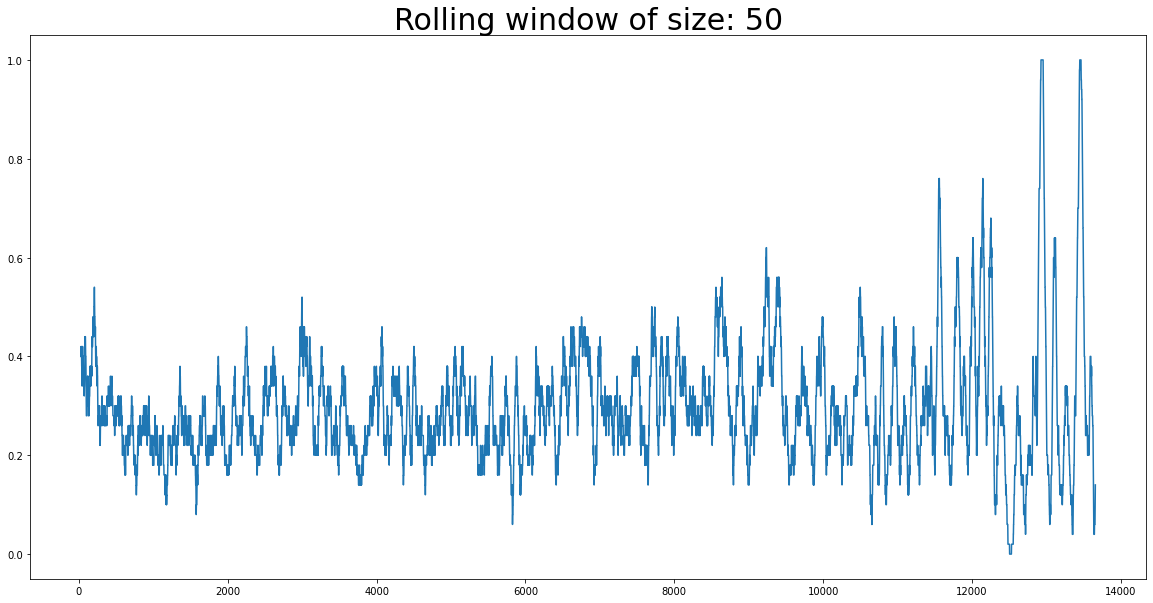

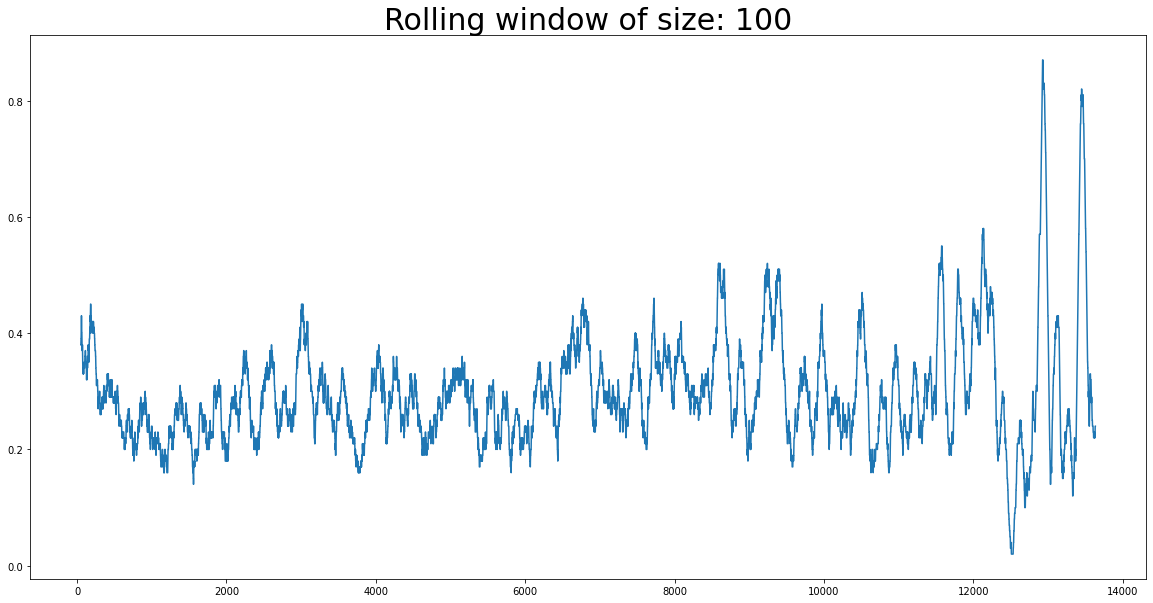

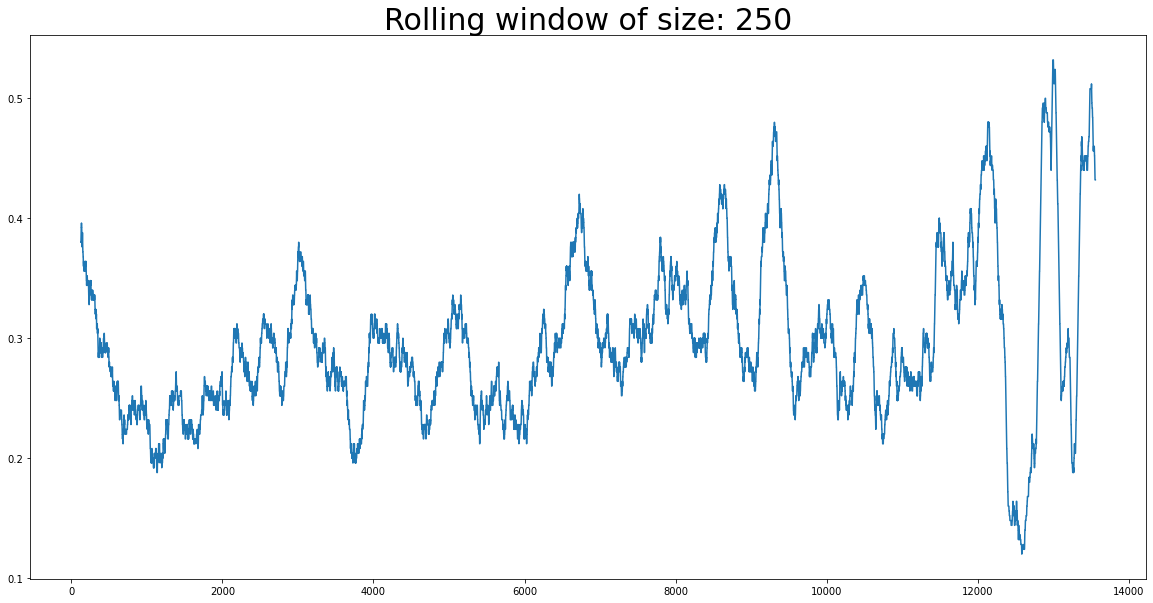

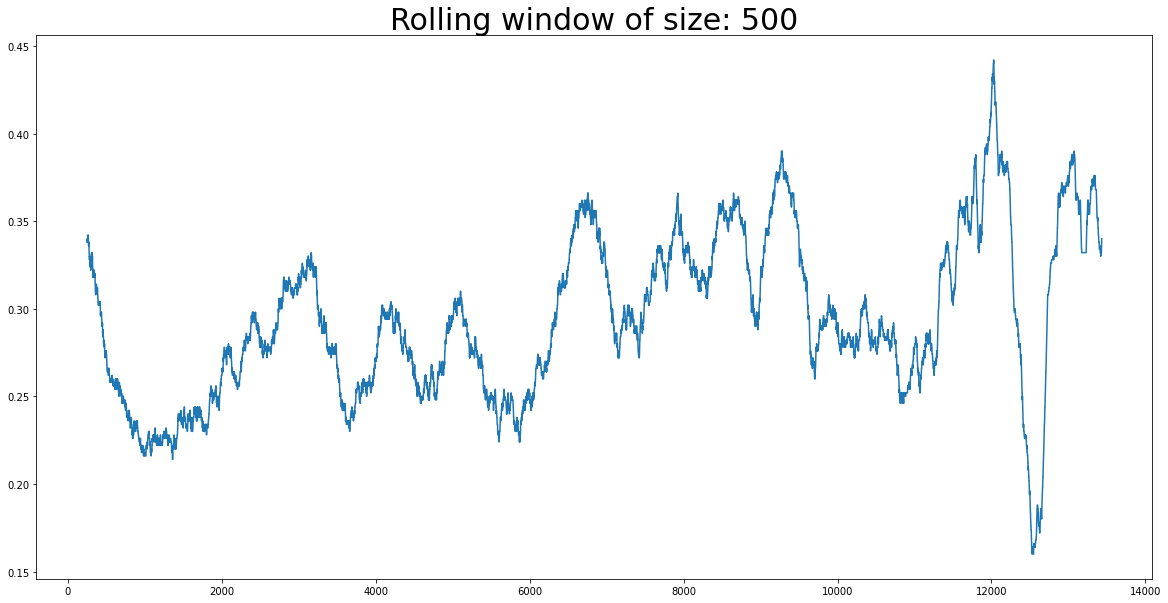

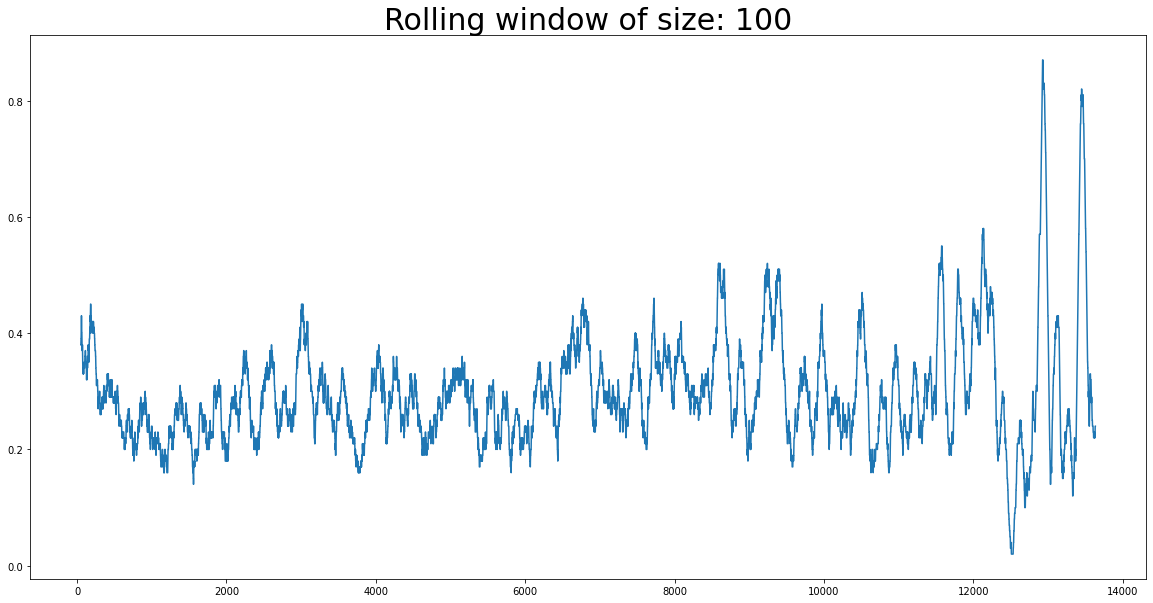

In [13]:
fraud_C_df = fraud_df[['C','Fraude']].sort_values('C', ascending = True)
fraud_C_df = fraud_C_df[~fraud_C_df['C'].isna()].reset_index(drop = True)

for i in [50,100,250,500,100]:
    fraud_aux = fraud_C_df['Fraude'].rolling(i, center = True).mean()
    plt.figure(figsize=(20,10))
    plt.plot(fraud_aux)
    plt.title('Rolling window of size: ' + str(i), fontdict={'size':30})
    plt.show()

### Comparacíón sencilla de la distribución de la columna K dado fraude y dado no fraude

Con el fin de verificar qué tan predictiva puede ser dicha variable en un potencial modelo y si vale la pena dejarla o no en el mismo. De haber diferencias sustanciales en distribución, se puede considerar mantener como columna y buscar estrategias de imputación

In [14]:
print(fraud_df.loc[fraud_df['Fraude'] == 1,'K'].describe())
print(fraud_df.loc[fraud_df['Fraude'] == 0,'K'].describe())

count    1453.000000
mean        0.631542
std         0.143431
min         0.120000
25%         0.540000
50%         0.630000
75%         0.730000
max         0.980000
Name: K, dtype: float64
count    2563.000000
mean        0.710761
std         0.151265
min         0.140000
25%         0.600000
50%         0.720000
75%         0.830000
max         0.990000
Name: K, dtype: float64


### Análisis univariado sencillo de la distribución condicional de Fraude dada la columna K

Busco entender la potencial capacidad predictiva de dicha variable

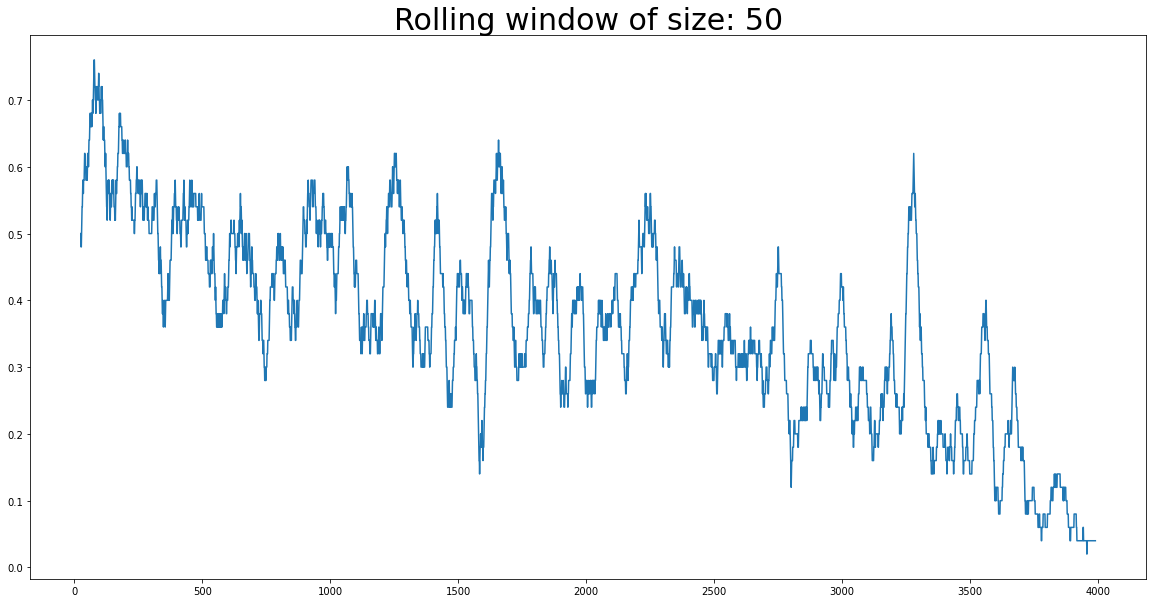

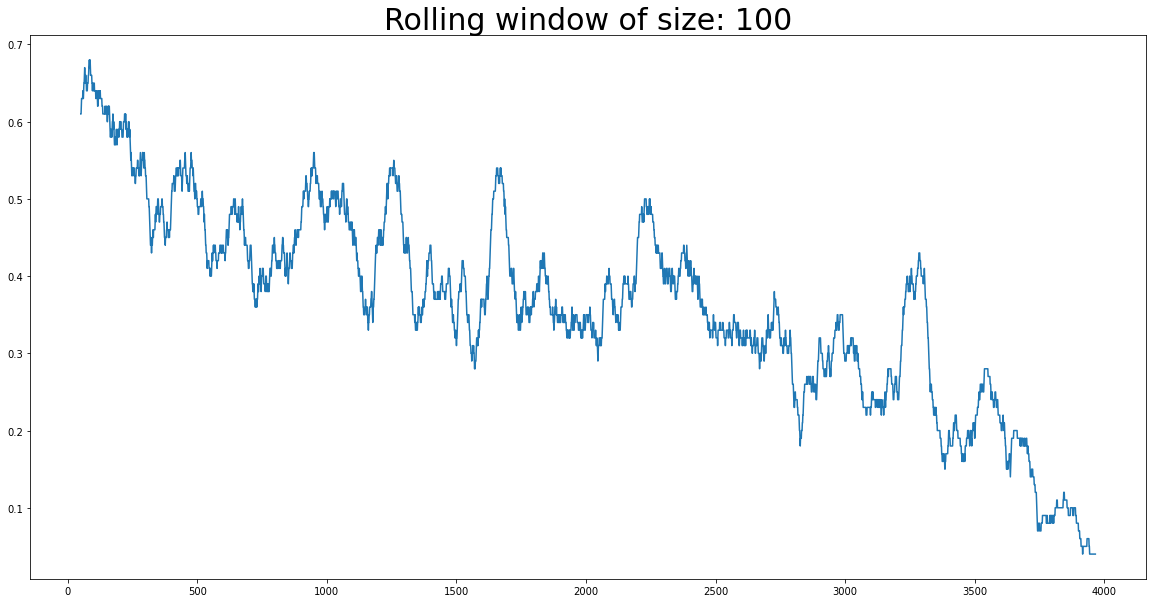

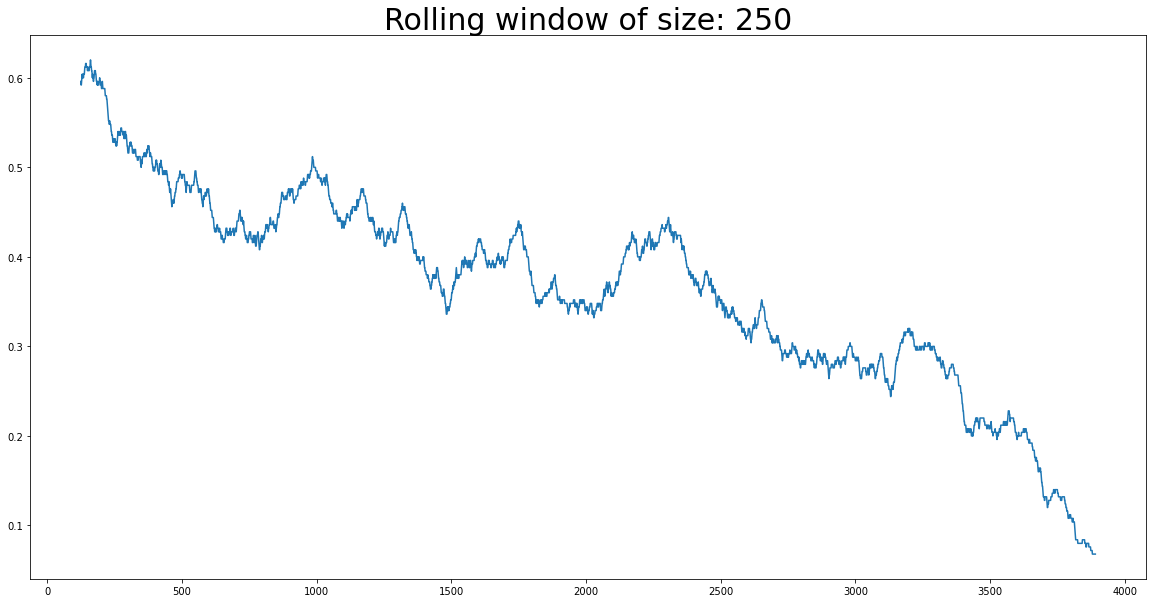

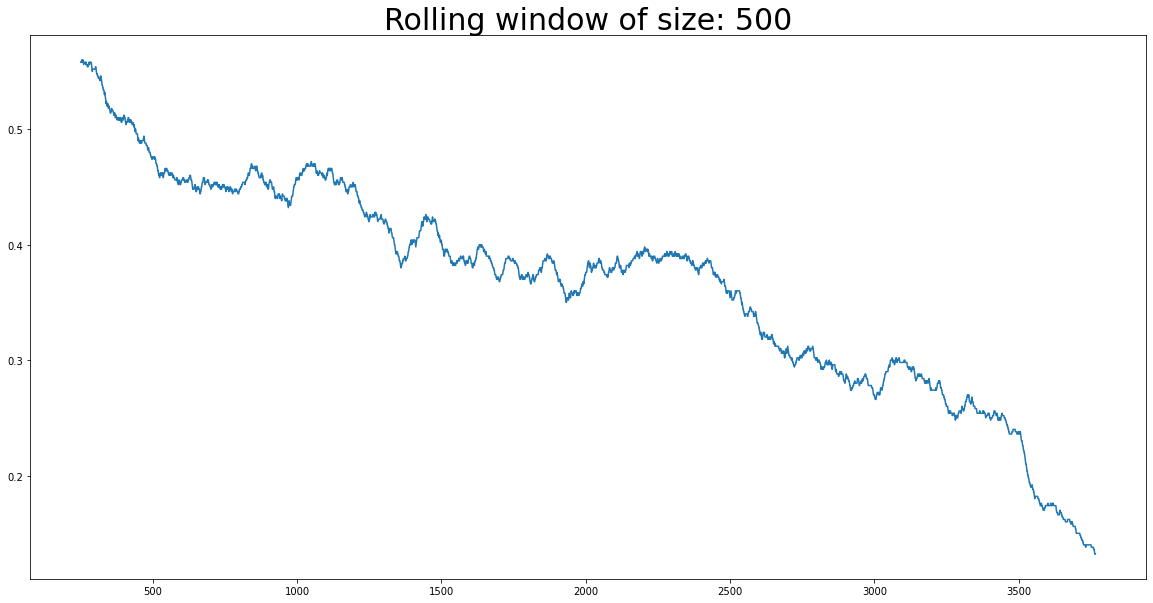

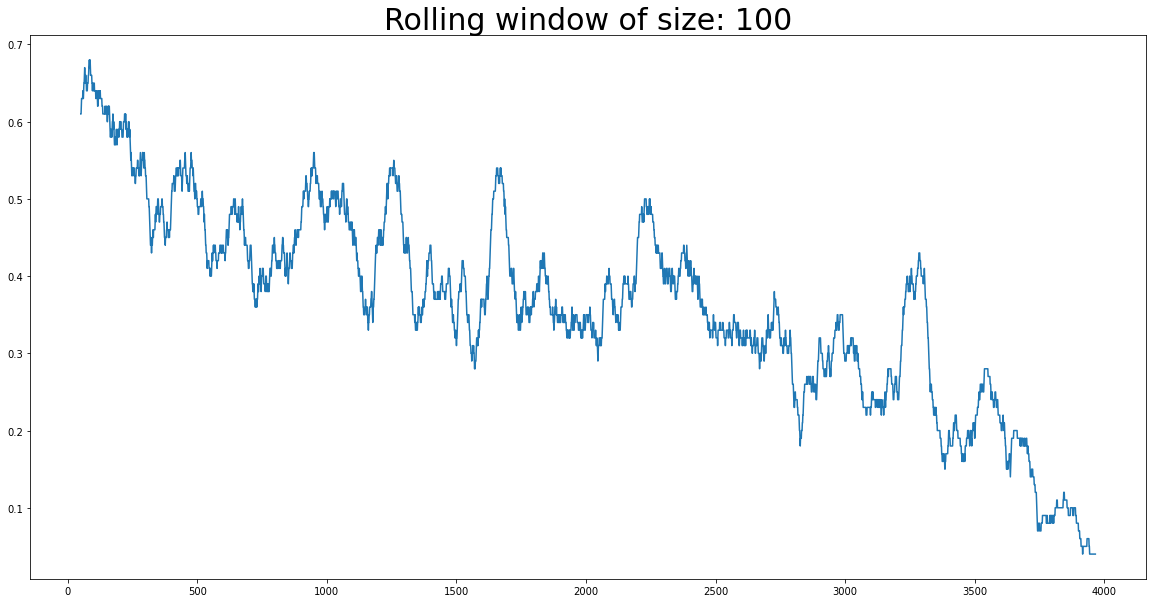

In [15]:
fraud_C_df = fraud_df[['K','Fraude']].sort_values('K', ascending = True)
fraud_C_df = fraud_C_df[~fraud_C_df['K'].isna()].reset_index(drop = True)

for i in [50,100,250,500,100]:
    fraud_aux = fraud_C_df['Fraude'].rolling(i, center = True).mean()
    plt.figure(figsize=(20,10))
    plt.plot(fraud_aux)
    plt.title('Rolling window of size: ' + str(i), fontdict={'size':30})
    plt.show()

Inicialmente, pensé eliminar la variable K dado la alta presencia de nulos. Sin embargo, por el análisis univariado realizado, creo que es pertinente, cuanto menos probar, la creación de un modelo sobre las transacciones sin dicha variable, y otro con la variable.

# Análisis univariados de distribución condicional de fraude con cada variable

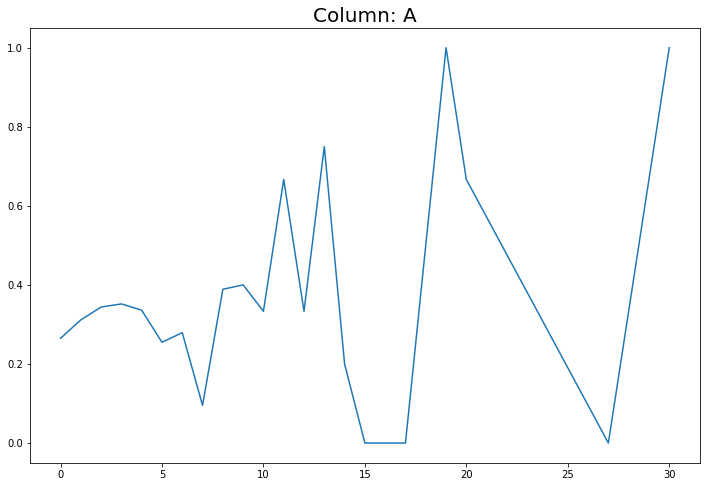

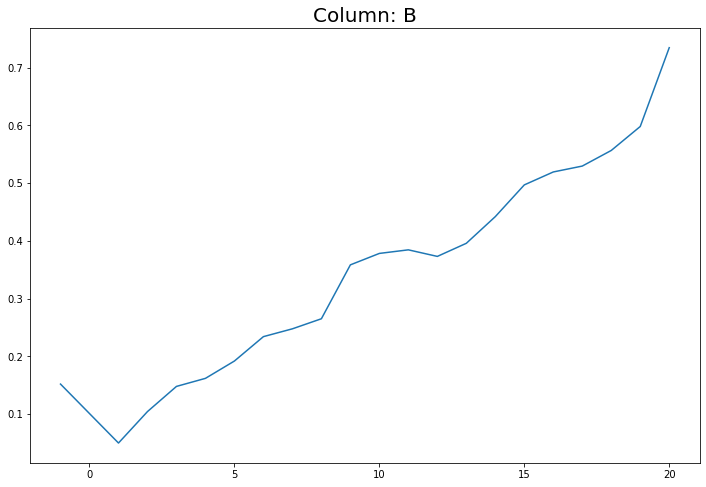

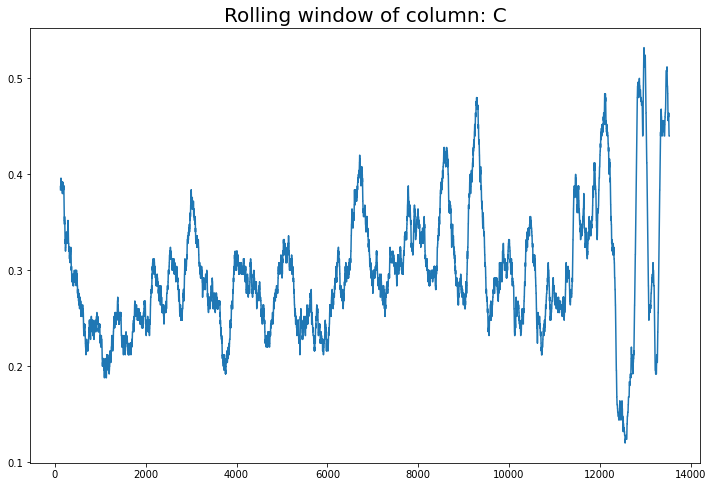

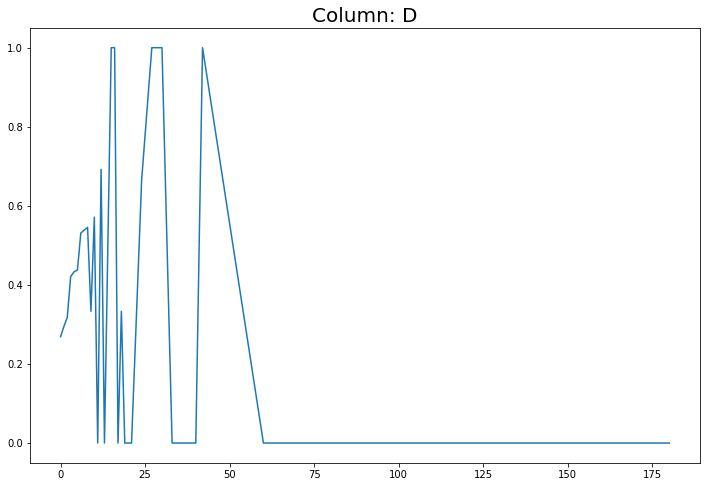

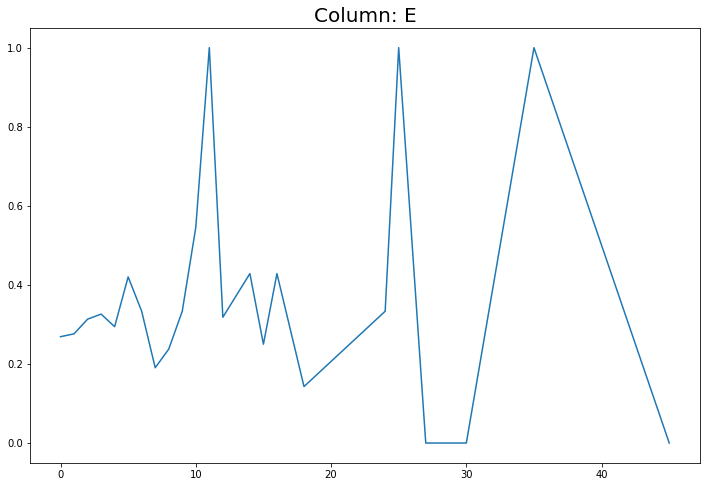

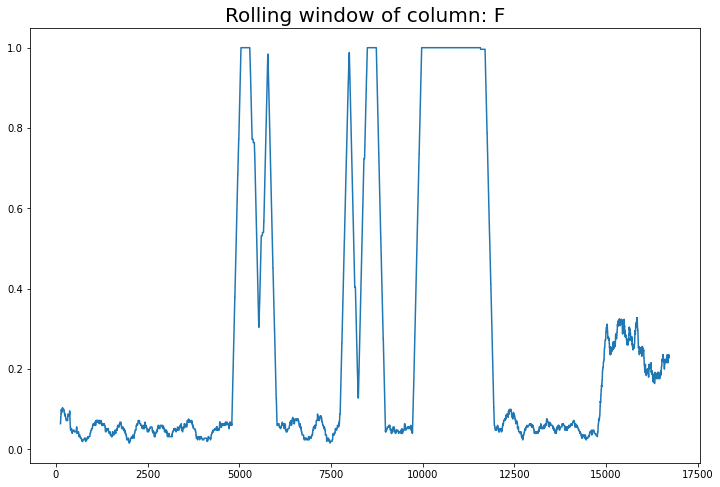

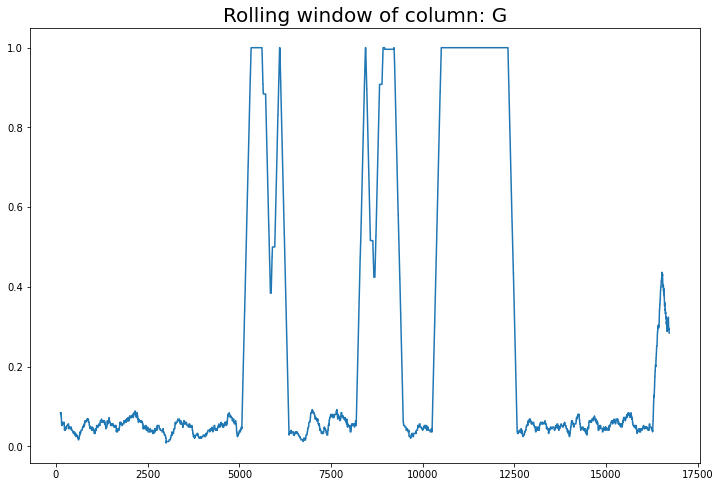

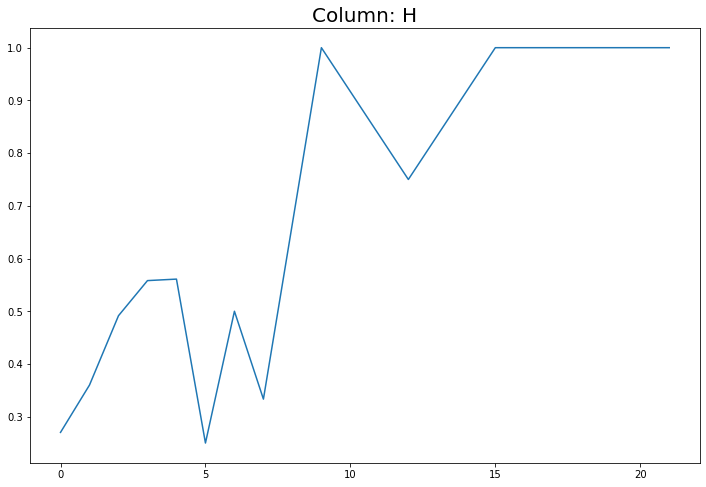

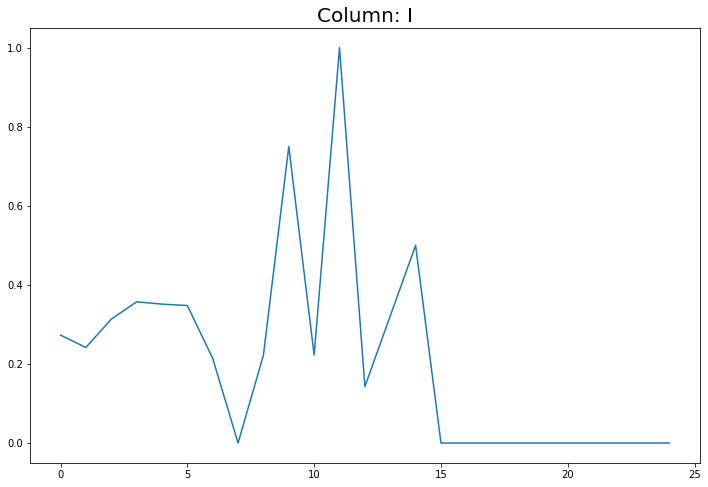

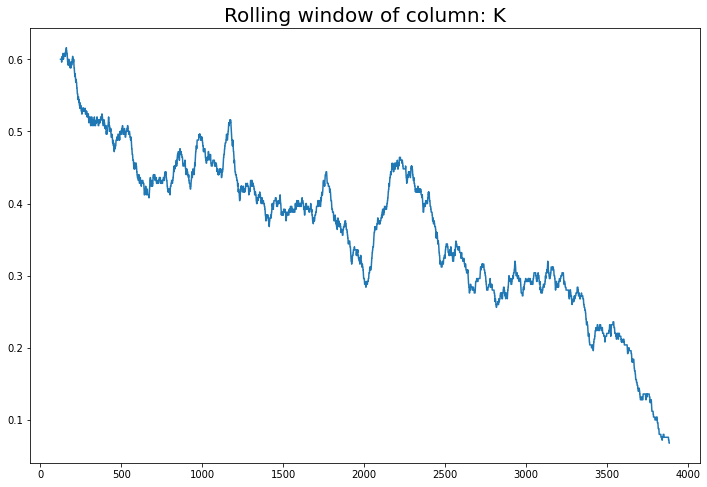

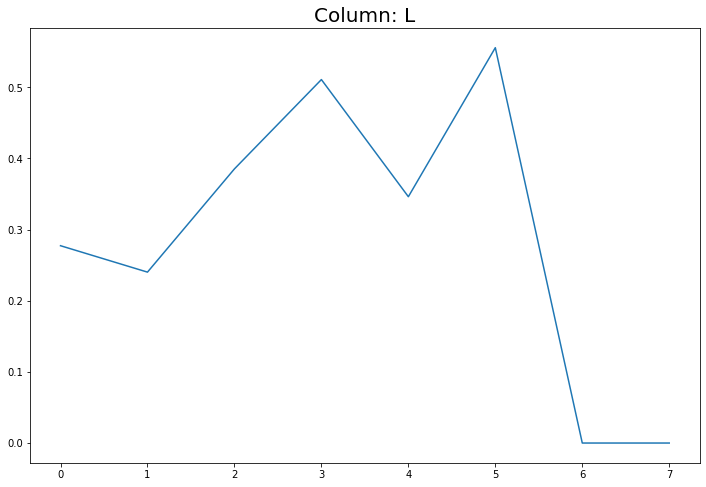

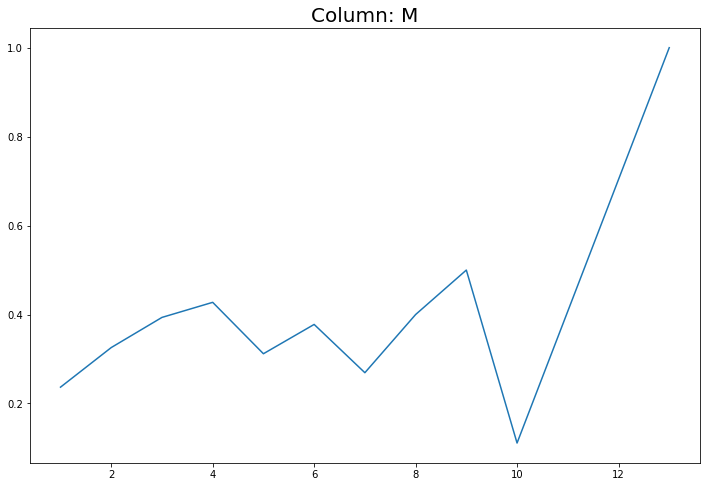

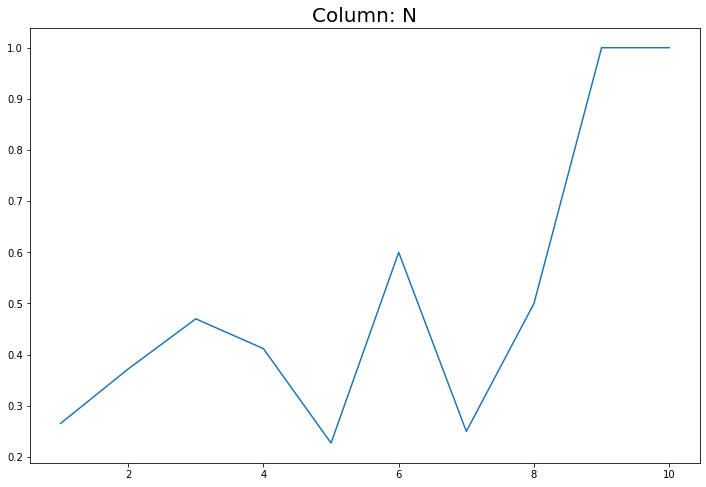

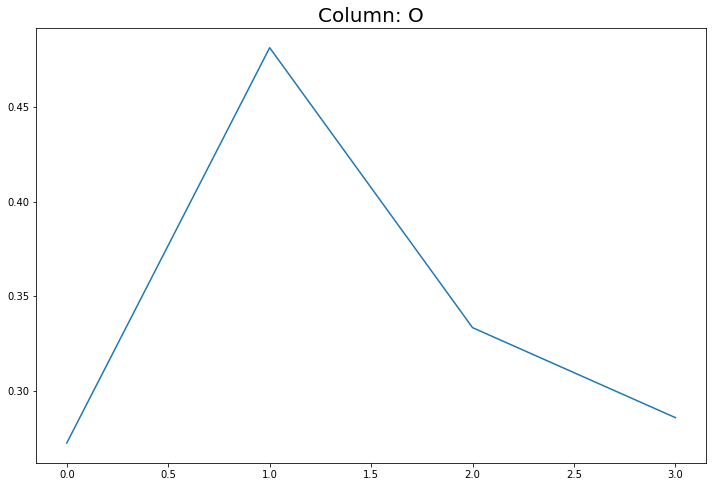

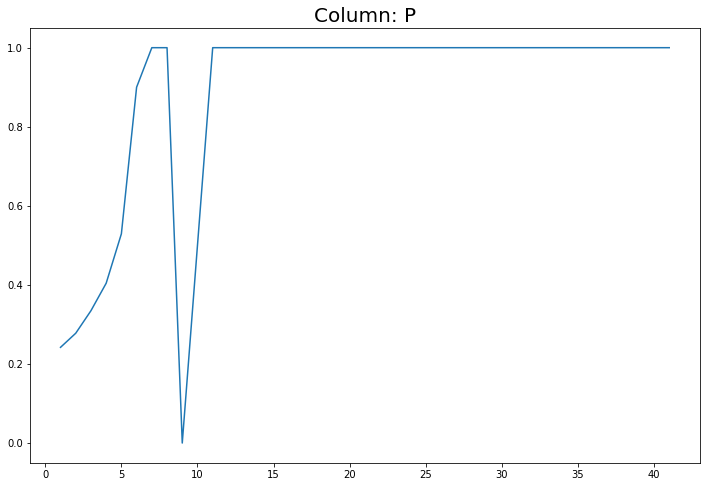

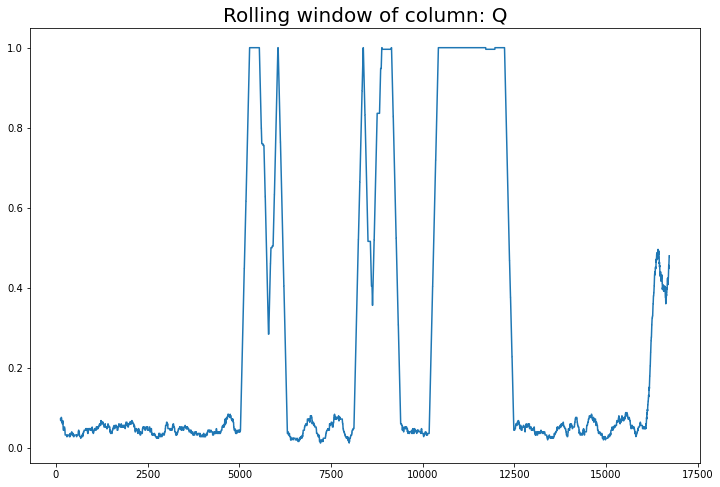

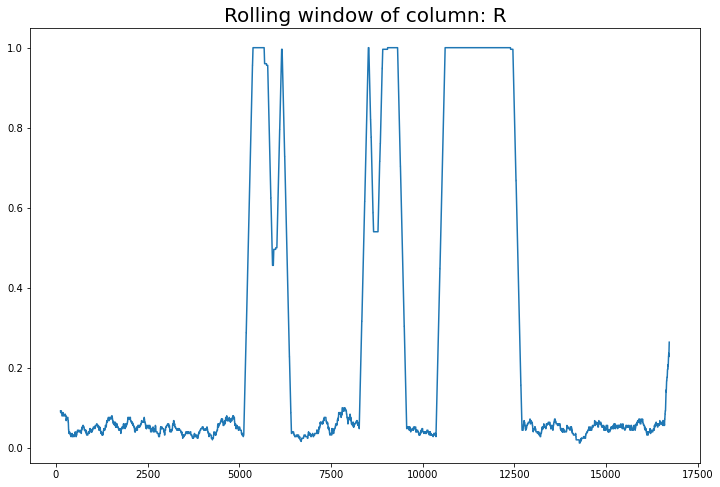

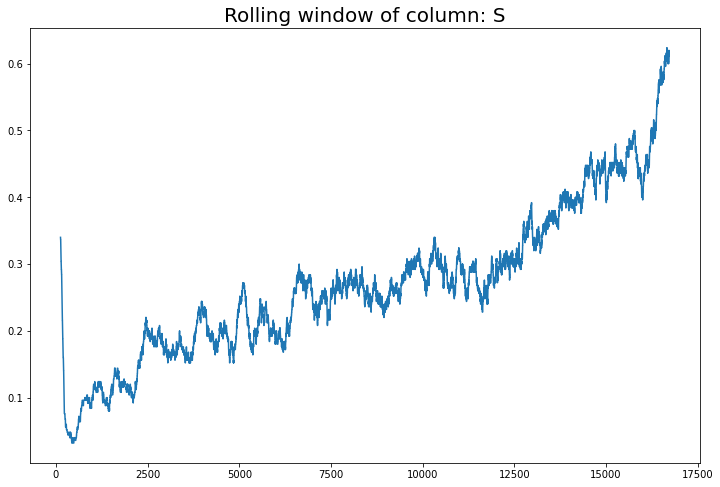

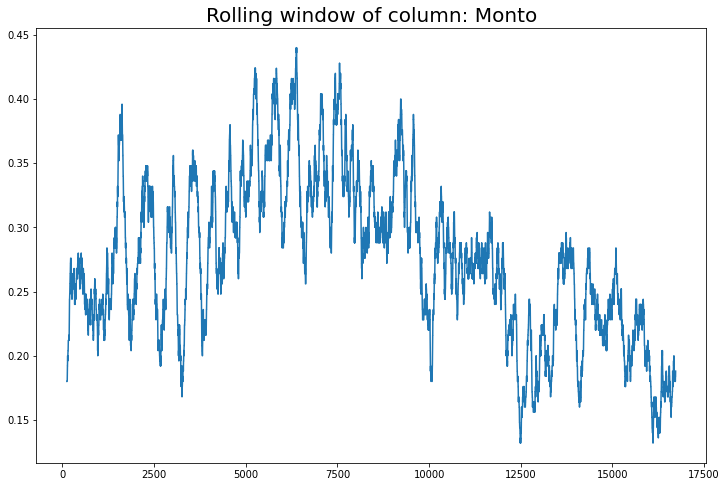

In [53]:
fig_size = (12,8)
font_size = 20
for i in fraud_df.columns[:-1]:
    
    aux_df = fraud_df[[i,'Fraude']].sort_values(i, ascending = True)
    aux_df = aux_df[~aux_df[i].isna()].reset_index(drop = True)
    
    aux_dtype = aux_df[i].dtypes
    
    if aux_dtype in ('int64','float64'):
        if aux_dtype == 'int64':            
            tmp_df = aux_df.groupby(i, as_index = False)[['Fraude']].mean()
            plt.figure(figsize=fig_size)
            plt.plot(tmp_df[i],tmp_df['Fraude'])
            plt.title('Column: ' + i, fontdict={'size':font_size})
            plt.show()
        else:
            aux_df = aux_df['Fraude'].rolling(250, center = True).mean()
            plt.figure(figsize=fig_size)
            plt.plot(aux_df)
            plt.title('Rolling window of column: ' + i, fontdict={'size':font_size})
            plt.show()

In [17]:
country_df = fraud_df.groupby('J', as_index = False).agg({'Fraude':['count','mean']})
country_df.columns = ['J', 'count', 'mean_Fraud_J']
country_df.sort_values('count', ascending = False)
country_list = list(country_df.loc[country_df['count']>12,'J'])
fraud_df = fraud_df[fraud_df['J'].isin(country_list)].reset_index(drop=True)
fraud_df.shape
country_df

,J,count,mean_Fraud_J
0,AR,9329,0.281488
1,AU,1,0.000000
2,BR,4428,0.248193
3,CA,12,0.000000
4,CH,1,0.000000
5,CL,1,0.000000
6,CO,1,0.000000
7,ES,314,0.939490
8,FR,2,0.000000
9,GB,8,0.000000


### Tratamiento variable categórica

Por simplicidad y efectividad, para todos los países que tienen 12 o menos transacciones (como se ve en la tabla anterior) eliminaré sus transacciones del DataFrame. Además, utilizaré la media proporción de fraudes por país como "encoding" de la variable categórica.

Esto lo haré durante el entrenamiento de cada modelo, con el fin de evitar data-leakege

# Desarrollaré modelo para imputar "inteligentemente" la variable C

Si los resultados son lo suficientemente buenos, usaré el modelo para imputar, de otra manera, y por simplicidad usaré una estrategia más sencilla de imputación

En general en todo el Notebook, únicamente usaré modelos de RandomForest (tanto en regresión como en clasificación) por varias razones:

1. Simplicidad: al ser una prueba técnica, probar una gran variedad de algoritmos de ML lo hace tedioso y lento. Prefiero agregar exploración de variables, análisis univariados y realizar una imputación de variables con modelación.

2. Son modelos usualmente robustos y que no tienden a realizar overfitting (con hiperparámetros adecuados y control de conjuntos de train, validation y test.

3. Permiten manejar el desbalance de clases (en clasificación) directamente, sin tener que realizar técnicas específicas. Además el desbalance se puede manejar con underfitting independiente para cada árbol, lo que ayuda a mantener todos los datos en el proceso y al mismo tiempo "lidiar" con ese problema

In [18]:
C_fraud_df = fraud_df.loc[~fraud_df['C'].isna(),tuple(fraud_df.columns[:-1])]
C_fraud_df.reset_index(drop = True, inplace = True)
C_fraud_df.drop(columns = ['K'], inplace = True )
X_C_data = C_fraud_df[C_fraud_df.columns[C_fraud_df.columns != 'C']]
y_C_data = C_fraud_df[['C']]

Como ya realicé un "shuffle" del DataFrame arriba, no lo realizo esta vez.

In [19]:
X_C_train_data, X_C_test_data, y_C_train_data, y_C_test_data  = train_test_split(X_C_data, y_C_data, test_size = 0.3,
                                                                                random_state = 123)

### Pequeña trampa:

Para garantizar presencia de cada país de train en validación, haré la imputación fuera del Cross Validation

Sé que puede afectar en Data Leakage. Lo correcto sería estratificar por países el K-Fold pero por simplicidad y tiempo no lo haré. 

La creación del conjunto de test y potencial posterior verificación de resultados ahí, puede ayudar en la mitigación del Data Leakage

In [20]:
aux_X_train = pd.concat([X_C_train_data, y_C_train_data], axis = 1, join = 'inner')
aux_X_test = pd.concat([X_C_test_data, y_C_test_data], axis = 1, join = 'inner')

country_df = aux_X_train.groupby('J', as_index = False)[['C']].mean()
country_df.columns = ['J', 'mean_Fraud_J']
cols_aux = X_C_train_data.columns

aux_X_train = aux_X_train.merge(country_df, on = 'J', how = 'inner')
aux_X_test = aux_X_test.merge(country_df, on = 'J', how = 'inner')

aux_X_train.drop(columns = 'J', inplace = True)
aux_X_test.drop(columns = 'J', inplace = True)

aux_X_train.rename(columns = {'mean_Fraud_J':'J'}, inplace = True)
aux_X_test.rename(columns = {'mean_Fraud_J':'J'}, inplace = True)

X_C_train_data = aux_X_train[cols_aux]
X_C_test_data = aux_X_test[cols_aux]

y_C_train_data = aux_X_train[['C']]
y_C_test_data = aux_X_test[['C']]

In [21]:
kfold = KFold( n_splits = 5, shuffle=True, random_state=123)

In [22]:
params = dict()
params['max_depth'] = [6,10,15]
params['min_samples_leaf'] = [250,100,50]
params['max_features'] = [6,12]

results_C_df = pd.DataFrame([], columns = ['k_fold_iter', 'max_depth', 'min_samples_leaf', 'max_features', 'r2_train', 
                                           'mean_absolute_percentage_error_train', 'mean_squared_error_train',
                                           'r2_val', 'mean_absolute_percentage_error_val', 'mean_squared_error_val'])

In [23]:
row = 0
k_fold_iter = 0
for train_index, test_index in kfold.split(X_C_train_data, y_C_train_data):
    
    X_train, X_val = X_C_train_data.iloc[train_index,:], X_C_train_data.iloc[test_index,:]
    y_train, y_val = y_C_train_data.iloc[train_index,:]['C'], y_C_train_data.iloc[test_index,:]['C']
    
    for i in params['max_depth']:
        for j in params['min_samples_leaf']:
            for k in params['max_features']:
        
                rf_C = RandomForestRegressor(n_estimators = 100, max_depth = i, min_samples_leaf = j,
                                             max_features = k, bootstrap = True, random_state = 123)
                
                rf_C.fit(X_train, y_train)
                
                y_predict_train = rf_C.predict(X_train)
                y_predict_val = rf_C.predict(X_val)
                
                tmp_tuple = [k_fold_iter,i,j,k]
                
                tmp_tuple += [r2_score(y_train, y_predict_train)]
                tmp_tuple += [mean_absolute_percentage_error(y_train, y_predict_train)]
                tmp_tuple += [mean_squared_error(y_train, y_predict_train)]
                
                tmp_tuple += [r2_score(y_val, y_predict_val)]
                tmp_tuple += [mean_absolute_percentage_error(y_val, y_predict_val)]
                tmp_tuple += [mean_squared_error(y_val, y_predict_val)]
                tmp_tuple = np.array(tmp_tuple)
                tmp_tuple = tmp_tuple.reshape((1,10))
                
                tmp_df = pd.DataFrame(tmp_tuple, columns = results_C_df.columns, index = [row])
                
                results_C_df = pd.concat([results_C_df, tmp_df])
                print(row)
                row+=1
                
    k_fold_iter+=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89


In [24]:
results_C_df.groupby(['max_depth','min_samples_leaf','max_features']).mean().sort_values('r2_val', ascending=False)

k_fold_iter  r2_train  \
max_depth min_samples_leaf max_features                          
10.0      50.0             12.0                  2.0  0.061917   
6.0       50.0             12.0                  2.0  0.040170   
10.0      50.0             6.0                   2.0  0.048985   
15.0      50.0             6.0                   2.0  0.054819   
                           12.0                  2.0  0.070286   
10.0      100.0            12.0                  2.0  0.041466   
6.0       100.0            12.0                  2.0  0.032152   
          50.0             6.0                   2.0  0.031879   
15.0      100.0            12.0                  2.0  0.042888   
10.0      100.0            6.0                   2.0  0.032537   
6.0       100.0            6.0                   2.0  0.025529   
15.0      100.0            6.0                   2.0  0.033443   
10.0      250.0            12.0                  2.0  0.020768   
15.0      250.0            12.0                  2.0  0.020767   
6.0       250.0            12.0                  2.0  0.019857   
15.0      250.0            6.0                   2.0  0.016966   
10.0      250.0            6.0                   2.0  0.016965   
6.0       250.0            6.0                   2.0  0.016342   

                                         mean_absolute_percentage_error_train  \
max_depth min_samples_leaf max_features                                         
10.0      50.0             12.0                                  1.747655e+18   
6.0       50.0             12.0                                  1.781705e+18   
10.0      50.0             6.0                                   1.808698e+18   
15.0      50.0             6.0                                   1.794962e+18   
                           12.0                                  1.731613e+18   
10.0      100.0            12.0                                  1.817632e+18   
6.0       100.0            12.0                                  1.826677e+18   
          50.0             6.0                                   1.831777e+18   
15.0      100.0            12.0                                  1.813925e+18   
10.0      100.0            6.0                                   1.849392e+18   
6.0       100.0            6.0                                   1.857943e+18   
15.0      100.0            6.0                                   1.854175e+18   
10.0      250.0            12.0                                  1.889862e+18   
15.0      250.0            12.0                                  1.889871e+18   
6.0       250.0            12.0                                  1.887880e+18   
15.0      250.0            6.0                                   1.896272e+18   
10.0      250.0            6.0                                   1.896254e+18   
6.0       250.0            6.0                                   1.897456e+18   

                                         mean_squared_error_train    r2_val  \
max_depth min_samples_leaf max_features                                       
10.0      50.0             12.0                      7.665414e+09  0.012391   
6.0       50.0             12.0                      7.843167e+09  0.012375   
10.0      50.0             6.0                       7.771086e+09  0.012077   
15.0      50.0             6.0                       7.723388e+09  0.012051   
                           12.0                      7.597045e+09  0.011877   
10.0      100.0            12.0                      7.832571e+09  0.011316   
6.0       100.0            12.0                      7.908681e+09  0.011249   
          50.0             6.0                       7.910896e+09  0.011190   
15.0      100.0            12.0                      7.820980e+09  0.011062   
10.0      100.0            6.0                       7.905521e+09  0.010204   
6.0       100.0            6.0                       7.962750e+09  0.010093   
15.0      100.0            6.0                       7.898105e+09  0.009

### No pareciera haber un modelo lo suficientemente bueno como para imputar por esta vía la variable C.

### Aclaro que sólo probé RandomForest y sólo algunos hiperparámetros; con más tiempo y, tal vez, más trabajo en feature engineering, se pueda encontrar uno mejor.

Como aclaración adicional: k-fold también debería verificar la varianza de los resultados para cada conjunto de hiperparámetros. De nuevo, por simplicidad, sólo uso la media

# Imputación variable C

### Verificar distribución

<AxesSubplot:>

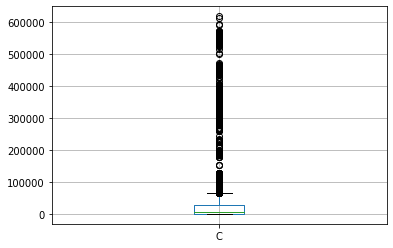

In [25]:
fraud_df.boxplot('C')

Al ser variable de cola pesada, la imputaré con la mediana. Se imputa durante el entrenamiento para evitar data-leakeage

# Modelo de clasificación de fraude

# Con variable K

Sólo entreno donde K no es nula

In [26]:
K_fraud_df = fraud_df.loc[~fraud_df['K'].isna(),:]
K_fraud_df.reset_index(drop = True, inplace = True)
X_K_data = K_fraud_df[K_fraud_df.columns[K_fraud_df.columns != 'Fraude']]
y_K_data = K_fraud_df[['Fraude']]

In [27]:
X_K_train_data, X_K_test_data, y_K_train_data, y_K_test_data  = train_test_split(X_K_data, y_K_data, test_size = 0.3,
                                                                                random_state = 123, stratify = y_K_data)

In [28]:
# Verificar que en test no queden países sin presencia en train
set(X_K_test_data['J'].unique()) == set(X_K_test_data['J'].unique()).intersection(set(X_K_train_data['J'].unique()))

True

In [29]:
kfold = KFold( n_splits = 5, shuffle=True, random_state=123)

In [30]:
params = dict()
params['max_depth'] = [3,6,10,15]
params['min_samples_leaf'] = [100,50,25]
params['max_features'] = [3,6,12]

results_K_df = pd.DataFrame([], columns = ['k_fold_iter', 'max_depth', 'min_samples_leaf', 'max_features', 'acc_train', 
                                           'recall_train', 'precision_train', 'auc_train', 'acc_val', 'recall_val',
                                           'precision_val', 'auc_val'])

### Pequeña trampa:

Para garantizar presencia de cada país de train en validación, haré la imputación fuera del Cross Validation

Sé que puede afectar en Data Leakage. Lo correcto sería estratificar por países el K-Fold pero por simplicidad y tiempo no lo haré. 

La creación del conjunto de test y potencial posterior verificación de resultados ahí, puede ayudar en la mitigación del Data Leakage

In [31]:
aux_X_train = pd.concat([X_K_train_data, y_K_train_data], axis = 1, join = 'inner')
aux_X_test = pd.concat([X_K_test_data, y_K_test_data], axis = 1, join = 'inner')

country_df = aux_X_train.groupby('J', as_index = False)[['Fraude']].mean()
country_df.columns = ['J', 'mean_Fraud_J']
cols_aux = X_K_train_data.columns

aux_X_train = aux_X_train.merge(country_df, on = 'J', how = 'inner')
aux_X_test = aux_X_test.merge(country_df, on = 'J', how = 'inner')

aux_X_train.drop(columns = 'J', inplace = True)
aux_X_test.drop(columns = 'J', inplace = True)

aux_X_train.rename(columns = {'mean_Fraud_J':'J'}, inplace = True)
aux_X_test.rename(columns = {'mean_Fraud_J':'J'}, inplace = True)

X_K_train_data = aux_X_train[cols_aux]
X_K_test_data = aux_X_test[cols_aux]

y_K_train_data = aux_X_train[['Fraude']]
y_K_test_data = aux_X_test[['Fraude']]

In [32]:
median_C = np.median(X_K_train_data.loc[~X_K_train_data['C'].isna(),'C'])
print(median_C)
X_K_train_data['C'] = X_K_train_data['C'].fillna(median_C)
X_K_test_data['C'] = X_K_test_data['C'].fillna(median_C)

6242.5


/home/gabriel/anaconda3/envs/personal_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/gabriel/anaconda3/envs/personal_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [33]:
row = 0
k_fold_iter = 0
for train_index, test_index in kfold.split(X_K_train_data, y_K_train_data):
    
    X_train, X_val = X_K_train_data.iloc[train_index,:], X_K_train_data.iloc[test_index,:]
    y_train, y_val = y_K_train_data.iloc[train_index,:]['Fraude'], y_K_train_data.iloc[test_index,:]['Fraude']
    
    for i in params['max_depth']:
        for j in params['min_samples_leaf']:
            for k in params['max_features']:
        
                rf_K = RandomForestClassifier(n_estimators = 100, max_depth = i, min_samples_leaf = j,
                                              max_features = k, bootstrap = True, random_state = 123,
                                              class_weight='balanced')
                
                rf_K.fit(X_train, y_train)
                
                y_predict_train = rf_K.predict(X_train)
                y_predict_val = rf_K.predict(X_val)
                
                y_predict_train_proba = rf_K.predict_proba(X_train)
                y_predict_val_proba = rf_K.predict_proba(X_val)
                
                tmp_tuple = [k_fold_iter,i,j,k]
                
                tmp_tuple += [accuracy_score(y_train, y_predict_train)]
                tmp_tuple += [recall_score(y_train, y_predict_train)]
                tmp_tuple += [precision_score(y_train, y_predict_train)]
                tmp_tuple += [roc_auc_score(y_train, y_predict_train_proba[:,1])]
                
                tmp_tuple += [accuracy_score(y_val, y_predict_val)]
                tmp_tuple += [recall_score(y_val, y_predict_val)]
                tmp_tuple += [precision_score(y_val, y_predict_val)]
                tmp_tuple += [roc_auc_score(y_val, y_predict_val_proba[:,1])]
                tmp_tuple = np.array(tmp_tuple)
                tmp_tuple = tmp_tuple.reshape((1,len(results_K_df.columns)))
                
                tmp_df = pd.DataFrame(tmp_tuple, columns = results_K_df.columns, index = [row])
                
                results_K_df = pd.concat([results_K_df, tmp_df])
                print(row)
                row+=1
                
    k_fold_iter+=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


In [34]:
grouped_K_df = results_K_df.groupby(['max_depth','min_samples_leaf','max_features'], as_index=False).mean().sort_values('auc_val', ascending=False)
grouped_K_df

,max_depth,min_samples_leaf,max_features,k_fold_iter,acc_train,recall_train,precision_train,auc_train,acc_val,recall_val,precision_val,auc_val
19,10.0,25.0,6.0,2.0,0.765057,0.808405,0.639154,0.863440,0.706690,0.719833,0.575663,0.796165
28,15.0,25.0,6.0,2.0,0.770937,0.809385,0.647201,0.867046,0.708477,0.724126,0.577687,0.796146
20,10.0,25.0,12.0,2.0,0.774857,0.811644,0.652216,0.870810,0.707757,0.719204,0.577079,0.794340
29,15.0,25.0,12.0,2.0,0.781183,0.814824,0.660698,0.875236,0.708472,0.715064,0.578338,0.793850
18,10.0,25.0,3.0,2.0,0.754811,0.796566,0.627402,0.850499,0.704553,0.728873,0.572575,0.793739
10,6.0,25.0,6.0,2.0,0.736992,0.793408,0.604536,0.840300,0.695645,0.737153,0.560560,0.793375
27,15.0,25.0,3.0,2.0,0.756770,0.794593,0.630450,0.852349,0.704907,0.721513,0.573625,0.792319
9,6.0,25.0,3.0,2.0,0.735744,0.783825,0.604637,0.833543,0.702059,0.740686,0.568220,0.791091
11,6.0,25.0,12.0,2.0,0.733339,0.802289,0.598510,0.839851,0.690298,0.743335,0.554111,0.787254
31,15.0,50.0,6.0,2.0,0.734051,0.785828,0.602105,0.828558,0.694935,0.729389,0.561081,0.783451


In [54]:
grouped_K_df.shape

(36, 12)

## Comentario:

A pesar de estar optimizando por AUC, sobre-escribo resultado ganador, cambiando max_depth de 10 a 15. Esto para ganar en F1 (aumento en recall y precision simultáneamente)

Dado que los hiperparámetros ganadores, son los más profundos dado un max_features de 6, se podría (probablemente) mejorar el modelo así:

1. Búsqueda alrededor de max_features de 6 para garantizar usar el mejor número de ese hiperparámetro
2. Seguir aumentando el tamaño de los árboles, dado que no pareciera haber overfitting.

Se podría también aumentar el n_estimators con el fin de buscar mayor estabilidad en los resultados, pero no parece ser absolutamente necesario

No lo hago por tiempo y simplicidad

In [35]:
grouped_K_df.reset_index(drop = True, inplace = True)
winner_params = grouped_K_df.iloc[0:1,0:3]
winner_params['max_depth'] = 15
winner_params

,max_depth,min_samples_leaf,max_features
0,15,25.0,6.0


### Recupero train, antes de k-fold, re-entreno con los mejores hiperparámetros y verifico resultados en test

In [36]:
row = 0
k_fold_iter = 0

max_depth = int(winner_params['max_depth'][0])
min_samples_leaf = int(winner_params['min_samples_leaf'][0])
max_features = int(winner_params['max_features'][0])

rf_K = RandomForestClassifier(n_estimators = 100, max_depth = max_depth, min_samples_leaf = min_samples_leaf,
                              max_features = max_features, bootstrap = True, random_state = 123,
                              class_weight='balanced')

median_C = np.median(X_K_train_data.loc[~X_K_train_data['C'].isna(),'C'])
X_K_train_data['C'] = X_K_train_data['C'].fillna(median_C)
X_K_test_data['C'] = X_K_test_data['C'].fillna(median_C)
                
rf_K.fit(X_K_train_data, y_K_train_data)

y_predict_train = rf_K.predict(X_K_train_data)
y_predict_val = rf_K.predict(X_K_test_data)

y_predict_train_proba = rf_K.predict_proba(X_K_train_data)
y_predict_val_proba = rf_K.predict_proba(X_K_test_data)

tmp_tuple = [k_fold_iter,max_depth,min_samples_leaf,max_features]

tmp_tuple += [accuracy_score(y_K_train_data, y_predict_train)]
tmp_tuple += [recall_score(y_K_train_data, y_predict_train)]
tmp_tuple += [precision_score(y_K_train_data, y_predict_train)]
tmp_tuple += [roc_auc_score(y_K_train_data, y_predict_train_proba[:,1])]

tmp_tuple += [accuracy_score(y_K_test_data, y_predict_val)]
tmp_tuple += [recall_score(y_K_test_data, y_predict_val)]
tmp_tuple += [precision_score(y_K_test_data, y_predict_val)]
tmp_tuple += [roc_auc_score(y_K_test_data, y_predict_val_proba[:,1])]
tmp_tuple = np.array(tmp_tuple)
tmp_tuple = tmp_tuple.reshape((1,len(results_K_df.columns)))

tmp_df = pd.DataFrame(tmp_tuple, columns = results_K_df.columns, index = [row])

tmp_df

/home/gabriel/anaconda3/envs/personal_env/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/gabriel/anaconda3/envs/personal_env/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/gabriel/anaconda3/envs/personal_env/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (

,k_fold_iter,max_depth,min_samples_leaf,max_features,acc_train,recall_train,precision_train,auc_train,acc_val,recall_val,precision_val,auc_val
0,0.0,15.0,25.0,6.0,0.77263,0.815143,0.648163,0.87016,0.72153,0.745413,0.591985,0.806601


### Feature importance

In [37]:
pd.DataFrame(np.transpose(np.array([X_K_train_data.columns, 
                                    rf_K.feature_importances_])),
            columns = ['variable','importance']).sort_values('importance', ascending = False)

,variable,importance
1,B,0.219568
9,J,0.211447
18,S,0.177721
10,K,0.106634
19,Monto,0.067973
2,C,0.062008
15,P,0.030051
16,Q,0.029928
11,L,0.023232
12,M,0.020903


# Sin variable K

Elimino por completo la columna y entreno

In [38]:
K_fraud_df = fraud_df.drop(columns = ['K'])
X_K_data = K_fraud_df[K_fraud_df.columns[K_fraud_df.columns != 'Fraude']]
y_K_data = K_fraud_df[['Fraude']]

In [39]:
X_K_train_data, X_K_test_data, y_K_train_data, y_K_test_data  = train_test_split(X_K_data, y_K_data, test_size = 0.3,
                                                                                random_state = 123, stratify = y_K_data)

In [40]:
# Verificar que en test no queden países sin presencia en train
set(X_K_test_data['J'].unique()) == set(X_K_test_data['J'].unique()).intersection(set(X_K_train_data['J'].unique()))

True

In [41]:
kfold = KFold( n_splits = 5, shuffle=True, random_state=123)

In [42]:
params = dict()
params['max_depth'] = [3,6,10,15]
params['min_samples_leaf'] = [100,50,25]
params['max_features'] = [3,6,12]

results_K_df = pd.DataFrame([], columns = ['k_fold_iter', 'max_depth', 'min_samples_leaf', 'max_features', 'acc_train', 
                                           'recall_train', 'precision_train', 'auc_train', 'acc_val', 'recall_val',
                                           'precision_val', 'auc_val'])

In [43]:
aux_X_train = pd.concat([X_K_train_data, y_K_train_data], axis = 1, join = 'inner')
aux_X_test = pd.concat([X_K_test_data, y_K_test_data], axis = 1, join = 'inner')

country_df = aux_X_train.groupby('J', as_index = False)[['Fraude']].mean()
country_df.columns = ['J', 'mean_Fraud_J']
cols_aux = X_K_train_data.columns

aux_X_train = aux_X_train.merge(country_df, on = 'J', how = 'inner')
aux_X_test = aux_X_test.merge(country_df, on = 'J', how = 'inner')

aux_X_train.drop(columns = 'J', inplace = True)
aux_X_test.drop(columns = 'J', inplace = True)

aux_X_train.rename(columns = {'mean_Fraud_J':'J'}, inplace = True)
aux_X_test.rename(columns = {'mean_Fraud_J':'J'}, inplace = True)

X_K_train_data = aux_X_train[cols_aux]
X_K_test_data = aux_X_test[cols_aux]

y_K_train_data = aux_X_train[['Fraude']]
y_K_test_data = aux_X_test[['Fraude']]

In [44]:
median_C = np.median(X_K_train_data.loc[~X_K_train_data['C'].isna(),'C'])
print(median_C)
X_K_train_data['C'] = X_K_train_data['C'].fillna(median_C)
X_K_test_data['C'] = X_K_test_data['C'].fillna(median_C)

6165.0


/home/gabriel/anaconda3/envs/personal_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/gabriel/anaconda3/envs/personal_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [45]:
row = 0
k_fold_iter = 0
for train_index, test_index in kfold.split(X_K_train_data, y_K_train_data):
    
    X_train, X_val = X_K_train_data.iloc[train_index,:], X_K_train_data.iloc[test_index,:]
    y_train, y_val = y_K_train_data.iloc[train_index,:]['Fraude'], y_K_train_data.iloc[test_index,:]['Fraude']
    
    for i in params['max_depth']:
        for j in params['min_samples_leaf']:
            for k in params['max_features']:
        
                rf_K = RandomForestClassifier(n_estimators = 100, max_depth = i, min_samples_leaf = j,
                                              max_features = k, bootstrap = True, random_state = 123,
                                              class_weight='balanced')
                
                rf_K.fit(X_train, y_train)
                
                y_predict_train = rf_K.predict(X_train)
                y_predict_val = rf_K.predict(X_val)
                
                y_predict_train_proba = rf_K.predict_proba(X_train)
                y_predict_val_proba = rf_K.predict_proba(X_val)
                
                tmp_tuple = [k_fold_iter,i,j,k]
                
                tmp_tuple += [accuracy_score(y_train, y_predict_train)]
                tmp_tuple += [recall_score(y_train, y_predict_train)]
                tmp_tuple += [precision_score(y_train, y_predict_train)]
                tmp_tuple += [roc_auc_score(y_train, y_predict_train_proba[:,1])]
                
                tmp_tuple += [accuracy_score(y_val, y_predict_val)]
                tmp_tuple += [recall_score(y_val, y_predict_val)]
                tmp_tuple += [precision_score(y_val, y_predict_val)]
                tmp_tuple += [roc_auc_score(y_val, y_predict_val_proba[:,1])]
                tmp_tuple = np.array(tmp_tuple)
                tmp_tuple = tmp_tuple.reshape((1,len(results_K_df.columns)))
                
                tmp_df = pd.DataFrame(tmp_tuple, columns = results_K_df.columns, index = [row])
                
                results_K_df = pd.concat([results_K_df, tmp_df])
                print(row)
                row+=1
                
    k_fold_iter+=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


In [46]:
grouped_no_K_df = results_K_df.groupby(['max_depth','min_samples_leaf','max_features'], as_index=False).mean().sort_values('auc_val', ascending=False)
grouped_no_K_df.reset_index(drop = True, inplace = True)
winner_params = grouped_no_K_df.iloc[0:1,0:3]
winner_params

,max_depth,min_samples_leaf,max_features
0,15.0,25.0,6.0


In [47]:
grouped_no_K_df

,max_depth,min_samples_leaf,max_features,k_fold_iter,acc_train,recall_train,precision_train,auc_train,acc_val,recall_val,precision_val,auc_val
0,15.0,25.0,6.0,2.0,0.772324,0.765284,0.561725,0.861988,0.737787,0.695580,0.515605,0.804047
1,15.0,25.0,3.0,2.0,0.760940,0.757463,0.545631,0.844031,0.734395,0.707440,0.510697,0.803932
2,10.0,25.0,6.0,2.0,0.757971,0.755674,0.541465,0.845965,0.733293,0.704592,0.509292,0.803402
3,15.0,25.0,12.0,2.0,0.781080,0.768688,0.574851,0.871311,0.738296,0.686600,0.516467,0.802046
4,10.0,25.0,3.0,2.0,0.754304,0.747473,0.536774,0.834659,0.733038,0.706534,0.508972,0.801647
5,10.0,25.0,12.0,2.0,0.763187,0.757534,0.548922,0.852006,0.731342,0.695876,0.506528,0.800677
6,10.0,50.0,6.0,2.0,0.745124,0.755991,0.523856,0.829862,0.724897,0.719425,0.498264,0.799458
7,15.0,50.0,6.0,2.0,0.748855,0.754204,0.528881,0.833753,0.727865,0.714511,0.502090,0.799247
8,15.0,50.0,3.0,2.0,0.743428,0.752110,0.521692,0.825161,0.726678,0.720824,0.500624,0.798508
9,15.0,50.0,12.0,2.0,0.755449,0.746693,0.538449,0.839547,0.729985,0.696125,0.504871,0.798348


In [48]:
row = 0
k_fold_iter = 0

max_depth = int(winner_params['max_depth'][0])
min_samples_leaf = int(winner_params['min_samples_leaf'][0])
max_features = int(winner_params['max_features'][0])

rf_no_K = RandomForestClassifier(n_estimators = 100, max_depth = max_depth, min_samples_leaf = min_samples_leaf,
                              max_features = max_features, bootstrap = True, random_state = 123,
                              class_weight='balanced')

median_C = np.median(X_K_train_data.loc[~X_K_train_data['C'].isna(),'C'])
X_K_train_data['C'] = X_K_train_data['C'].fillna(median_C)
X_K_test_data['C'] = X_K_test_data['C'].fillna(median_C)
                
rf_no_K.fit(X_K_train_data, y_K_train_data)

y_predict_train = rf_no_K.predict(X_K_train_data)
y_predict_val = rf_no_K.predict(X_K_test_data)

y_predict_train_proba = rf_no_K.predict_proba(X_K_train_data)
y_predict_val_proba = rf_no_K.predict_proba(X_K_test_data)

tmp_tuple = [k_fold_iter,max_depth,min_samples_leaf,max_features]

tmp_tuple += [accuracy_score(y_K_train_data, y_predict_train)]
tmp_tuple += [recall_score(y_K_train_data, y_predict_train)]
tmp_tuple += [precision_score(y_K_train_data, y_predict_train)]
tmp_tuple += [roc_auc_score(y_K_train_data, y_predict_train_proba[:,1])]

tmp_tuple += [accuracy_score(y_K_test_data, y_predict_val)]
tmp_tuple += [recall_score(y_K_test_data, y_predict_val)]
tmp_tuple += [precision_score(y_K_test_data, y_predict_val)]
tmp_tuple += [roc_auc_score(y_K_test_data, y_predict_val_proba[:,1])]
tmp_tuple = np.array(tmp_tuple)
tmp_tuple = tmp_tuple.reshape((1,len(results_K_df.columns)))

tmp_df = pd.DataFrame(tmp_tuple, columns = results_K_df.columns, index = [row])

tmp_df

/home/gabriel/anaconda3/envs/personal_env/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/gabriel/anaconda3/envs/personal_env/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/gabriel/anaconda3/envs/personal_env/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (

,k_fold_iter,max_depth,min_samples_leaf,max_features,acc_train,recall_train,precision_train,auc_train,acc_val,recall_val,precision_val,auc_val
0,0.0,15.0,25.0,6.0,0.773915,0.766037,0.563997,0.862237,0.74639,0.692919,0.528084,0.810327


In [49]:
pd.DataFrame(np.transpose(np.array([X_K_train_data.columns, 
                                    rf_no_K.feature_importances_])),
            columns = ['variable','importance']).sort_values('importance', ascending = False)

,variable,importance
1,B,0.279973
9,J,0.246269
17,S,0.201042
2,C,0.084833
18,Monto,0.080437
14,P,0.035095
11,M,0.022049
10,L,0.011283
15,Q,0.010278
0,A,0.010023


# Modelo final

Dado que recall y precision son mejores en el modelo que incluye la variable K que al eliminarla, el modelo final sería: si K no es nulo, se usa el modelo que la incluye para predecir; en caso contrario, se usa el modelo que excluye dicha variable.

Al haberse entrenado ambos modelos en conjuntos diferentes, no sería correcto generar un reporte de métricas general, usando ambos como lo describí porque estaría mezclando conjuntos de entrenamiento y test.

# Pregunta 2:

Dado que puedo predecir probabilidad de fraude con bastante confianza, dados los buenos niveles de AUC en ambos modelos, puedo decir:

E(ganancia) = Monto * ( 0.25 * ( 1-P(Fraude) ) -  P(Fraude) )

Donde:

E(ganancia) := es el valor esperado de ganancias
P(Fraude) es la probabilidad estimada por el modelo de que una transacción sea fraude.

Despejando:

E(ganancia) = Monto * ( 0.25 - 1.25 * P(Fraude) )

Si se quiere:

E(ganancia) = Monto * ( 1 - 1.25 * P(Fraude) ) >= 0

Entonces:

Monto * ( 1 - 1.25 * P(Fraude) ) >= 0
Monto - 1.25 * Monto * P(Fraude) >= 0
Monto >= 1.25 * Monto * P(Fraude)

Como Monto >= 0

Entonces:

1 >= 1.25 * P(Fraude)

Finalmente:

0.8 >= P(Fraude)

Es decir, si la probabilidad estimada de que una transacción sea fraude es menor o igual a 0.8, se debería realizar dicha transacción, en otro caso, no.

In [51]:
(y_predict_val_proba[:,1]>=0.8).sum() / len(y_predict_val_proba)

0.04530168150346192

Por ejemplo, en el modelo que excluye la variable K, se rechazarían el 4.53% de las transacciones, que en test, son las que tienen probabilidad mayor a 80% de ser fraude.